In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,  DataCollatorWithPadding
from transformers import get_scheduler
import torch
from datasets import Dataset, DatasetDict
import pandas as pd
import os
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence

# new file
from rules import preprocess_texts, custom_loss, augment_features


In [2]:
# Define the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Llamacha/QuBERTa")
model = AutoModelForSequenceClassification.from_pretrained("Llamacha/QuBERTa", num_labels=24)  # adjust num_labels as necessary

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at Llamacha/QuBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def split_document(text, max_length=250, overlap=50):
    # Split text into words
    words = text.split()
    parts = []
    if len(words) <= max_length:
        return [text]  # Return the entire text if it's short enough

    i = 0
    while i < len(words):
        # Ensure that we don't exceed the text length
        end_index = min(i + max_length, len(words))
        # Join the selected range of words back into a string
        chunk_text = " ".join(words[i:end_index])
        parts.append(chunk_text)
        i += (max_length - overlap)
    
    return parts

In [4]:
def remove_numbers(text):
    # Remove numbers using regular expression
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers


In [5]:
def load_and_preprocess(directory_paths):
    processed_data = []
    label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}
    for dialect, directory_path in directory_paths.items():
        print("dialect: ", dialect)
        for filename in os.listdir(directory_path):
            if filename.endswith('.txt'):
                print("filename: ", filename)
                file_path = os.path.join(directory_path, filename)
                with open(file_path, 'r', encoding='latin-1') as file:
                    text = file.read().strip()
                    text = remove_numbers(text)

                    # Determine tags for this text
                    tags = preprocess_texts(text) 
                    print("File is tagged with: ", tags)

                    # Split the original text into chunks (not the processed_text)
                    chunks = split_document(text)
                    print("document is in ", len(chunks), " chunks")

                    # Process each chunk
                    for chunk in chunks:
                        # Append tags to each chunk and tokenize
                        chunk_with_tags = f"{chunk} {tags}"  # Append tags to each chunk
                        encoded_text = tokenizer(chunk_with_tags, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
                        input_ids_list = encoded_text['input_ids'].squeeze(0).tolist()
                        attention_mask_list = encoded_text['attention_mask'].squeeze(0).tolist()
                        processed_data.append({
                            'input_ids': input_ids_list,
                            'attention_mask': attention_mask_list,
                            'labels': label_dict[dialect]
                    })
    return processed_data



In [6]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)
    
    labels = torch.tensor(labels)
    
    return {'input_ids': input_ids, 'attention_mask': attention_masks, 'labels': labels}


In [7]:

# Define your directory paths correctly
directory_paths = {
    # 'other': '../language_resources/dialects_mixed_txt/other_quechua/',
    'qub': '../language_resources/dialects_mixed_txt/qub',
    'quf': '../language_resources/dialects_mixed_txt/quf',
    'quh': '../language_resources/dialects_mixed_txt/quh',
    'quk': '../language_resources/dialects_mixed_txt/quk',
    'qul': '../language_resources/dialects_mixed_txt/qul',
    'qup': '../language_resources/dialects_mixed_txt/qup',
    'quw': '../language_resources/dialects_mixed_txt/quw',
    'qux': '../language_resources/dialects_mixed_txt/qux',
    'quy': '../language_resources/dialects_mixed_txt/quy',
    'quz': '../language_resources/dialects_mixed_txt/quz', 
    'qvc': '../language_resources/dialects_mixed_txt/qvc',
    'qve': '../language_resources/dialects_mixed_txt/qve',  
    'qvi': '../language_resources/dialects_mixed_txt/qvi',
    'qvm': '../language_resources/dialects_mixed_txt/qvm',
    'qvn': '../language_resources/dialects_mixed_txt/qvn',
    'qvo': '../language_resources/dialects_mixed_txt/qvo',
    'qvw': '../language_resources/dialects_mixed_txt/qvw',
    'qvz': '../language_resources/dialects_mixed_txt/qvz',
    'qwh': '../language_resources/dialects_mixed_txt/qwh',
    'qxl': '../language_resources/dialects_mixed_txt/qxl',
    'qxh': '../language_resources/dialects_mixed_txt/qxh',
    'qxn': '../language_resources/dialects_mixed_txt/qxn',
    'qxo': '../language_resources/dialects_mixed_txt/qxo',
    'qxr': '../language_resources/dialects_mixed_txt/qxr',
    # 'southern': '../language_resources/dialects_mixed_txt/southern_quechua'
}


# go through loading & processing
processed_data = load_and_preprocess(directory_paths)

dialect:  qub
filename:  processed_Huallaga_Huánuco_Quechua_qub.txt
File is tagged with:  <TAG_tayta> <TAG_tata> <TAG_papa> <TAG_allpu> <TAG_pacha> <TAG_alpa> <TAG_allpa> <TAG_yacu> <TAG_inti> <TAG_indi> <TAG_rupay> <TAG_quilla> <TAG_runa> <TAG_nuna>
document is in  536  chunks
dialect:  quf
filename:  processed_Lambayeque_Quechua_quf.txt
File is tagged with:  <TAG_tayta> <TAG_tata> <TAG_yaya> <TAG_papa> <TAG_pacha> <TAG_alpa> <TAG_allpa> <TAG_yaku> <TAG_unu> <TAG_inti> <TAG_indi> <TAG_rupay> <TAG_killa> <TAG_runa> <TAG_kari> <TAG_nuna> <TAG_qari>
document is in  734  chunks
dialect:  quh
filename:  MUL028R071I001.txt
File is tagged with:  <TAG_pacha> <TAG_indi> <TAG_qhari> <TAG_qari>
document is in  6  chunks
filename:  MUL028R109I001.txt
File is tagged with:  <TAG_tata> <TAG_yaku> <TAG_qhari> <TAG_qari>
document is in  6  chunks
filename:  MUL028R061I001.txt
File is tagged with:  <TAG_pacha> <TAG_qhari> <TAG_qari>
document is in  6  chunks
filename:  MUL028R095I001.txt
File is tagge

In [8]:

# Create the dataset directly from a dictionary
dataset = Dataset.from_dict({'input_ids': [x['input_ids'] for x in processed_data],
                             'attention_mask': [x['attention_mask'] for x in processed_data],
                             'labels': [x['labels'] for x in processed_data]})
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
split_datasets = dataset.train_test_split(test_size=0.15)
train_dataset = split_datasets['train']
val_dataset = split_datasets['test']

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, sampler=train_sampler)



In [9]:
# List to store accuracy per epoch
epoch_accuracy = []

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    epoch_accuracy.append(acc)  # Store accuracy
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [10]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,  # Increased epochs
    per_device_train_batch_size=10,  # Slightly larger batch size
    per_device_eval_batch_size=15,
    warmup_steps=500,  # Adjusted warmup steps
    weight_decay=0.01,  # Adjusted weight decay
    # learning_rate=5e-5,  # Added explicit learning rate
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    lr_scheduler_type='cosine',  # Using a cosine learning rate scheduler
    save_strategy="epoch",  # Save the model at each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [11]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/9580 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
def get_predictions(model, dataloader):
    model.eval()  # Put model in evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch['input_ids'].to(model.device),
                      'attention_mask': batch['attention_mask'].to(model.device)}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    
    return predictions, true_labels


  0%|          | 0/47 [00:00<?, ?it/s]

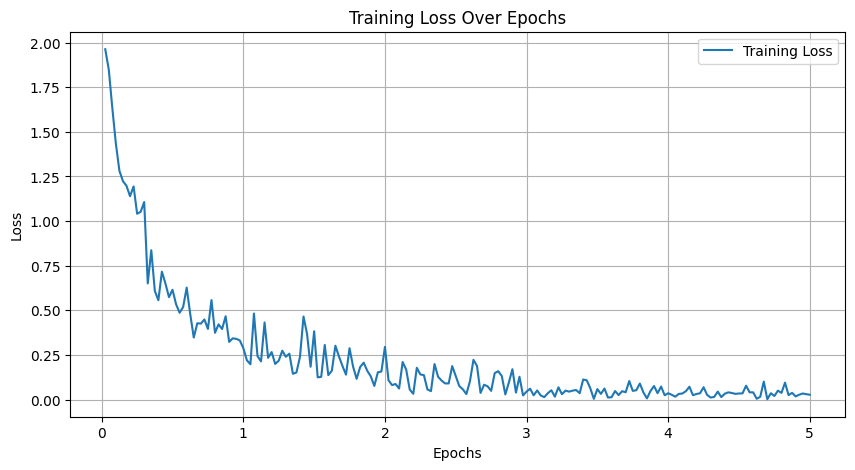

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Plot training loss
training_loss = trainer.state.log_history

epochs = [x['epoch'] for x in training_loss if 'loss' in x]
loss = [x['loss'] for x in training_loss if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import classification_report

# Assuming you have a DataLoader for your validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)  # Adjust batch size as needed

# Get predictions
predictions, true_labels = get_predictions(model, val_dataloader)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=[label for label in directory_paths.keys()])
print("Classification Report:\n", report)


/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_92681/64439305.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_92681/64439305.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)


Classification Report:
               precision    recall  f1-score   support

         quh       0.99      0.89      0.93       150
         quk       1.00      1.00      1.00         6
         qux       0.97      1.00      0.99        38
         quy       1.00      1.00      1.00       410
         quz       0.82      0.99      0.90        80
         qwh       1.00      0.93      0.97        15
         qxo       1.00      1.00      1.00         6

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.98      0.97      0.97       705



<Figure size 1000x700 with 0 Axes>

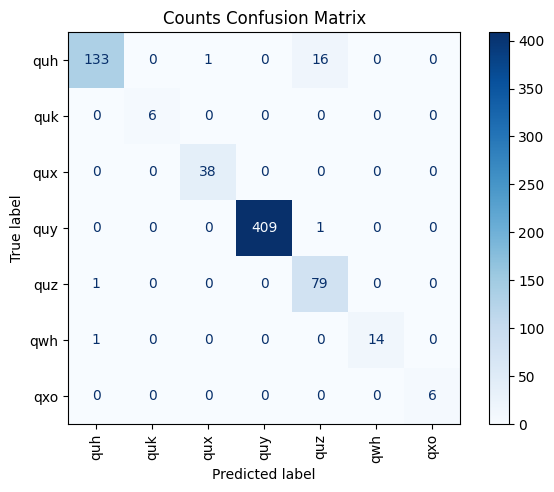

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=list(range(len(directory_paths))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label for label in directory_paths.keys()])

# Increase figure size
plt.figure(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels and adjust font size
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout
plt.title("Counts Confusion Matrix")
plt.show()

Normalized Confusion Matrix

<Figure size 1000x700 with 0 Axes>

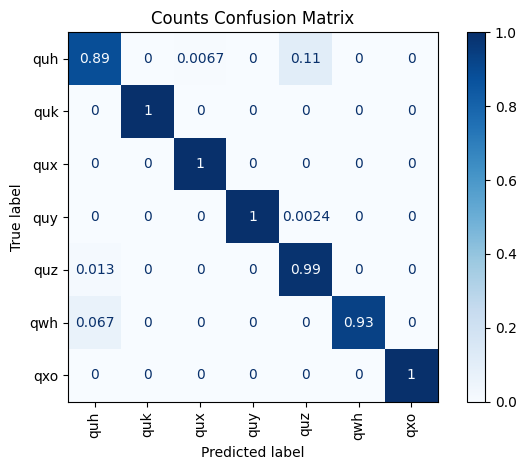

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=list(range(len(directory_paths))), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label for label in directory_paths.keys()])

# Increase figure size
plt.figure(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels and adjust font size
plt.yticks(fontsize=10)
plt.title("Normalized Confusion Matrix")
plt.tight_layout()  # Adjust layout
plt.show()

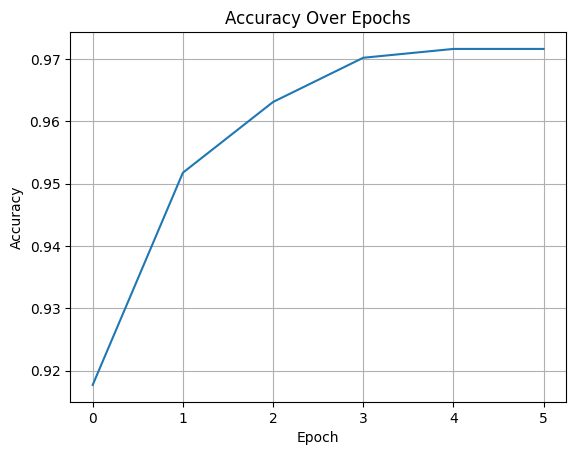

In [27]:
plt.plot(epoch_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

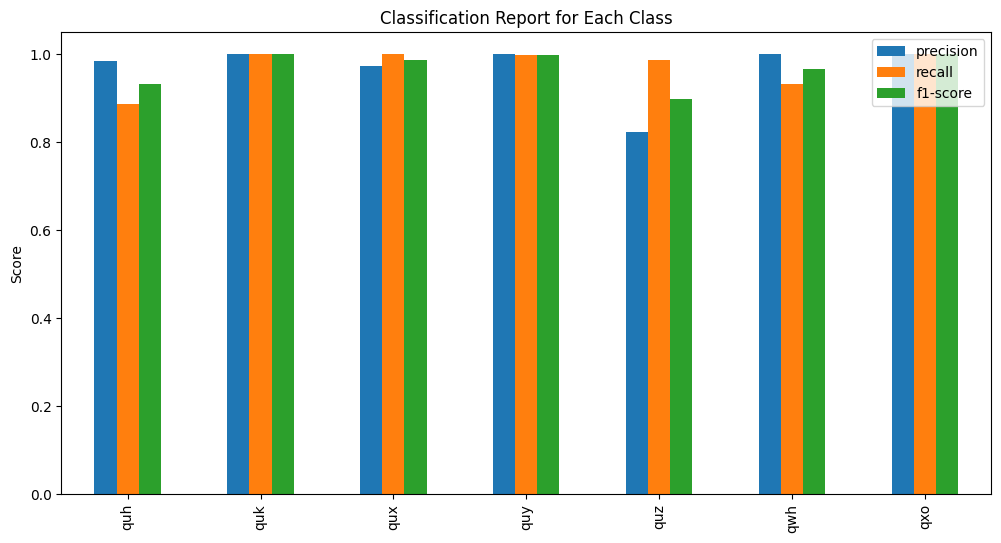

In [28]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(true_labels, predictions, target_names=directory_paths.keys(), output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)  # Drop averages/total
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title('Classification Report for Each Class')
plt.ylabel('Score')
plt.show()
